<a href="https://colab.research.google.com/github/Ilvecho/Project_2/blob/main/P2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch

from google.colab import files
files.upload()

In [2]:
raw_data = pd.read_csv('term-deposit-marketing-2020.csv')

# transform the labels 
raw_data.loc[raw_data['y'] == 'no', 'y'] = 0
raw_data.loc[raw_data['y'] == 'yes', 'y'] = 1

# Missing values

In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [3]:
print(raw_data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


We have 40'000 samples, made of 13 features and 1 label.

The features have different data type -> we will need to convert some features in order to have consistent data type across all features.

At first look, it seems that there are no missing values.

In [4]:
raw_data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,no


However, by looking at the first samples, we notice that there are some values "unknown" -> there actually are missing values.

Let's see if there are other values equivalent to "missing".

Note that we should check categorical features only

In [5]:
for key in raw_data.keys():

  if raw_data.loc[:, key].dtype == 'O':
    print('---------------------------------')
    print('Value counts for feature: ' + key)
    print(raw_data.loc[:, key].value_counts())
    print('+++++++++++++++++++++++++++++++++')

---------------------------------
Value counts for feature: job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: marital
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: default
no     39191
yes      809
Name: default, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: hous

From the print above, we can see that the only missing values are marked as Unknown.

We need to think about how to deal with missing values:
*   We could leave them missing (i.e. additional category 'unknown')
*   We could fill in with the most frequent value of the feature (risk of unbalancing the dataset)
*   We could remove the rows (risk of information loss)
*   We could build a predictor based on the remaining features. 

# Label Balance

In [3]:
raw_data.loc[raw_data['y'] == 'no', 'y'] = 0
raw_data.loc[raw_data['y'] == 'yes', 'y'] = 1

In [7]:
print(raw_data['y'].value_counts())
print('Average probability of yes: ', raw_data['y'].sum() / raw_data.shape[0])

0    37104
1     2896
Name: y, dtype: int64
Average probability of yes:  0.0724


The labels of the dataset are **very unbalanced** with a ratio of almost 13:1 between No and Yes.

We will need to keep this in mind while developing the model, especially because the Yes are **more important** than the No

# Outliers

Let's see which data are outside 3 standard deviations (99,7%).

Note: **categorical** features cannot have outliers, hence we will check only the numeric features.
Note, the feature "day" is categorical even if its datatype is int. 

In [29]:
numerical_keys = ['age', 'balance', 'duration', 'campaign']

for key in numerical_keys:
# key = 'duration'
  mean = raw_data[key].mean()
  std = raw_data[key].std()

  tmp = raw_data.loc[raw_data[key] >= mean + 3* std, 'y']
  print('------------------')
  print(f'The number of outliers in feature {key} is: {tmp.shape[0]}')
  print(f'The probability of the outliers to say yes is: { tmp.sum() / tmp.shape[0]}')

------------------
The number of outliers in feature age is: 89
The probability of the outliers to say yes is: 0.449438202247191
------------------
The number of outliers in feature balance is: 673
The probability of the outliers to say yes is: 0.09212481426448738
------------------
The number of outliers in feature duration is: 865
The probability of the outliers to say yes is: 0.5988439306358382
------------------
The number of outliers in feature campaign is: 836
The probability of the outliers to say yes is: 0.03229665071770335


We see that there are few samples outside the 99.7%, especially for features balance, durtion and campaign.

Let's now analyze the distribution of the features, with an eye on the label as well

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

for key in numerical_keys:
  fig = px.histogram(raw_data, x=key, color='y', marginal='box', title='Distribution of attribute '+key)
  fig.show()

1/ Feature 'age'
The distribution is quite wide, with a small number of outliers. By zooming in the outlier region, we notice that the ratio between yes and no is much higher than in the center of the distribution.

This could indicate that samples that are outliers in this feature have an higher probability of saying yes. We will **not remove** the outliers from this feature

2/ Feature 'balance'
The distribution of the feature is very narrow, with outlier tails on both sides. 
The left outliers region is not particularly long, and it is mainly filled with 'no' samples -> we might remove the samples with balance lower than -1000. It also makes sense logically: a broke individual is not going to open a deposit.
The right region of outliers has two trends: in the first part (balance < 5000) we notice an increase of 'yes' samples, afterwards the outliers are mainly 'no'. 

In this case, we might **keep only** the samples with balance between -1000 and 5000

3/ Feature 'duration'
Once again the distribution is quite narrow, with a long outlier tail on the positive side.
Looking at the boxplot we notice that the distribution of 'yes' is centered around an higher value than the 'no'. This makes sense logically: if a customer accept an offer, the phone call will be longer - while if they are not interested, the call will be much shorted.

After the value 2000 (i.e. 33 minutes), however, the number of samples drastically reduces -> the samples in this area are not statistically meaningful, so we are going to **remove** them.

4/ Feature 'campaign'
Also in this case the distribution is narrow with a long positive tail.
There is a very limited number of 'yes' samples with campaign > 10, while the 'no's are much more. We can draw two conclusions from this:

a) we shall **remove** the outliers with campaign > 10

b) we shall advise our client to avoid calling the same individual more than 10 times


# Correlation

let's use frequency plots and probability of Yes to see if there are correlations between features/categories and the label 

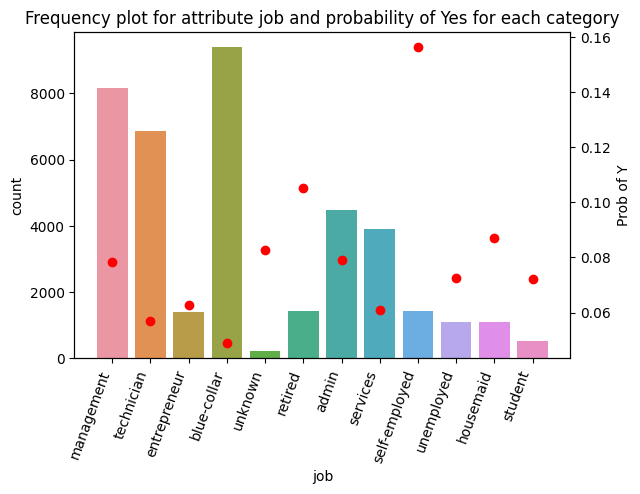

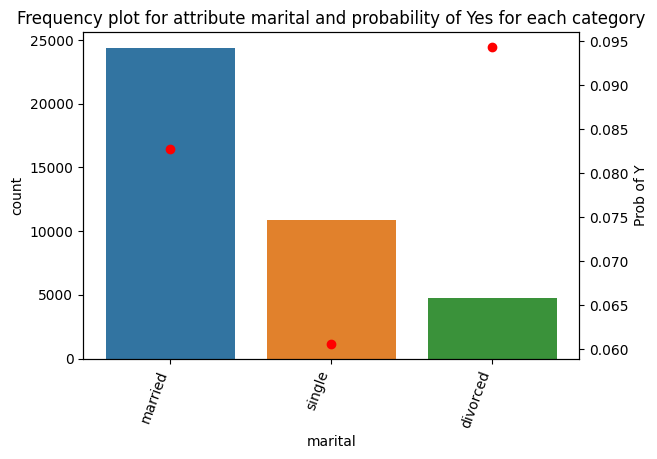

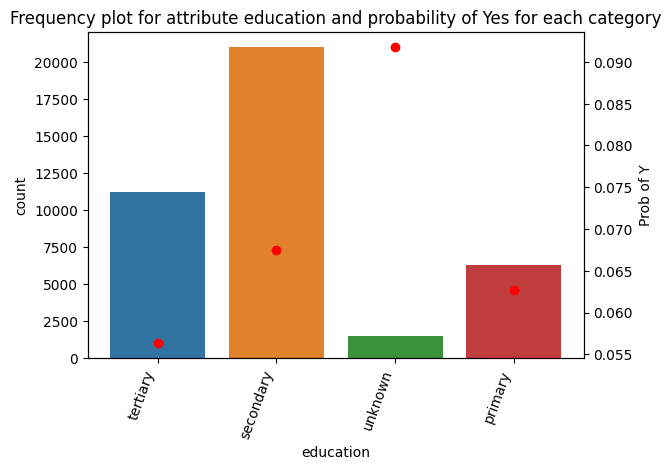

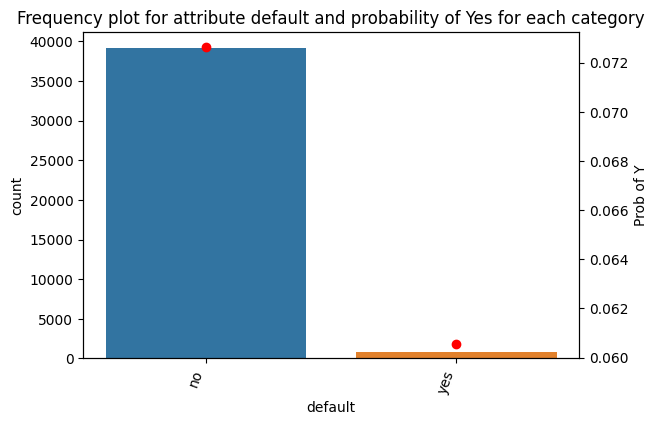

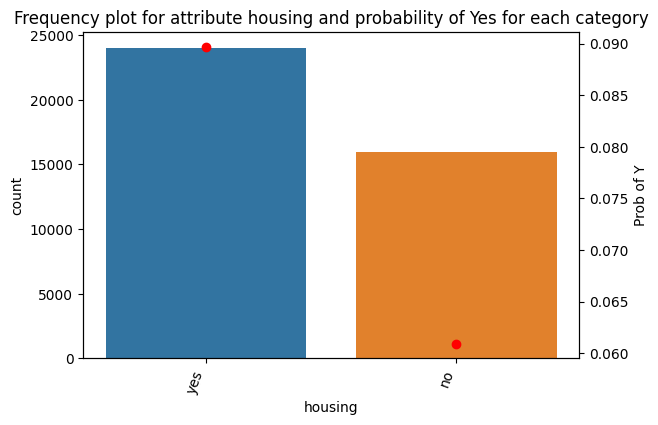

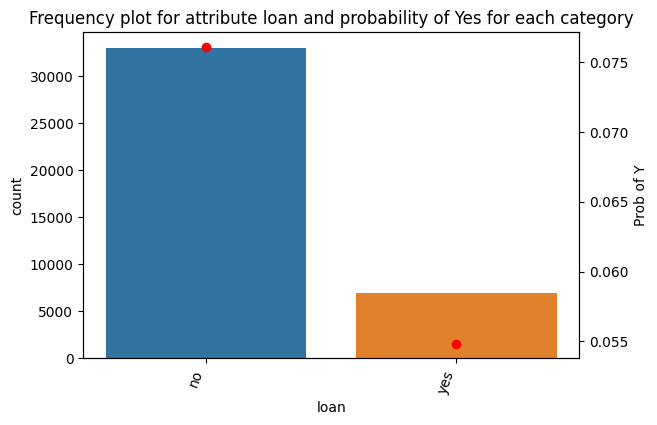

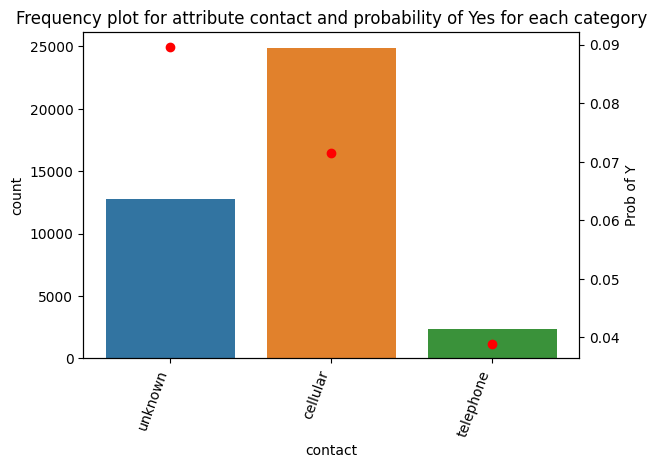

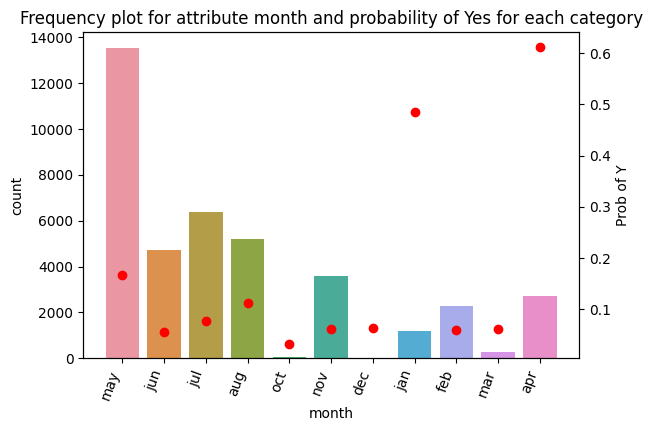

In [37]:
for key in raw_data.keys():

  if key == 'y':
    break 
    
  # Features of Type Object -> it will exclude 5 features: age, balance, day, duration and campain
  if raw_data.loc[:, key].dtype == 'O':
    
    # create the axes to plot
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Category frequency plot
    sns.countplot(x=key, data=raw_data, ax=ax1).set(title='Frequency plot for attribute '+ key + ' and probability of Yes for each category')

    # group by category to compute the probability of Y
    grp = raw_data.groupby(key)
    ax2.scatter(grp['y'].aggregate(np.mean).keys(), grp['y'].aggregate(np.mean), color='r')
    ax2.set_ylabel('Prob of Y')

    fig.autofmt_xdate(rotation=70)


Let's now address the features that were left out: 

Age, balance, day, duration, campaign.

Let's quantize in bins age, balance and duration;

For campaign we cut off the tail of the distribution, which is very long;

For the day, we don't need to do anything - simply plot as above, with a small not to add a -1 in the X in scatterplot

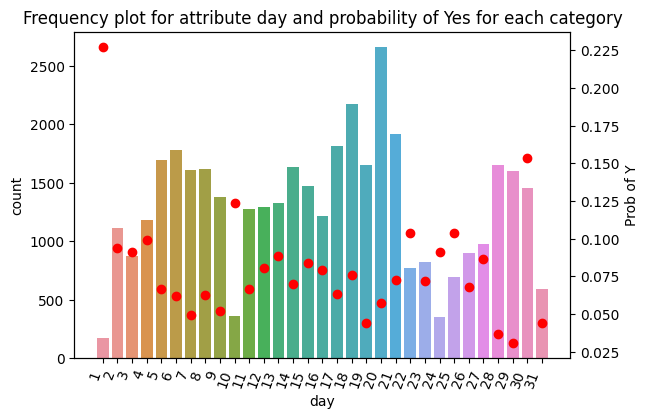

In [38]:
key = 'day'
# create the axes to plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Category frequency plot
sns.countplot(x=key, data=raw_data, ax=ax1).set(title='Frequency plot for attribute '+ key + ' and probability of Yes for each category')

# group by category to compute the probability of Y
grp = raw_data.groupby(key)
ax2.scatter(grp['y'].aggregate(np.mean).keys() -1, grp['y'].aggregate(np.mean), color='r')
ax2.set_ylabel('Prob of Y')

fig.autofmt_xdate(rotation=70)

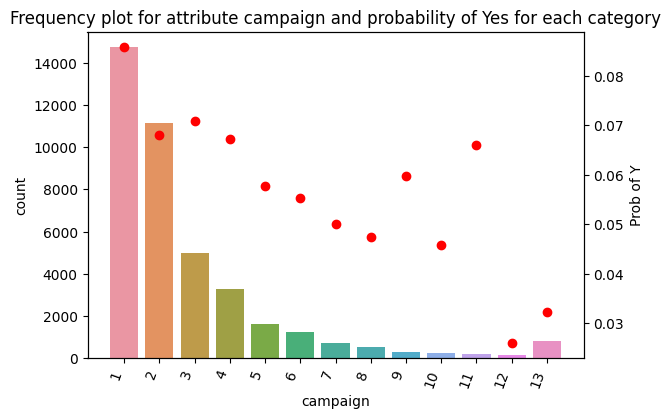

In [39]:
key = 'campaign'
cut_tail_data = raw_data.copy()

# cut the tail of the distribution: we group together all the values that are beyond 5 standard deviations
cut_tail_data.loc[raw_data[key] >= (raw_data[key].mean() + 3 * raw_data[key].std()), key ] = int(raw_data[key].mean() + 3 * raw_data[key].std()) +1

# create the axes to plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Category frequency plot
sns.countplot(x=key, data=cut_tail_data, ax=ax1).set(title='Frequency plot for attribute '+ key + ' and probability of Yes for each category')

# group by category to compute the probability of Y
grp = cut_tail_data.groupby(key)
ax2.scatter(grp['y'].aggregate(np.mean).keys() -1, grp['y'].aggregate(np.mean), color='r')
ax2.set_ylabel('Prob of Y')

fig.autofmt_xdate(rotation=70)

There is correlation between the feature and the label. 

Let's see how this relationship is in the outlier region

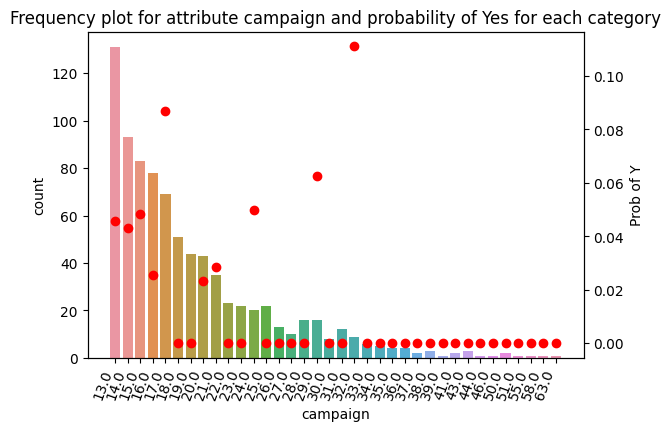

In [40]:
key = 'campaign'
cut_core_data = raw_data.copy()

# cut the tail of the distribution: we group together all the values that are inside 5 standard deviations
cut_core_data.loc[raw_data[key] < (raw_data[key].mean() + 3 * raw_data[key].std()), key ] = np.nan
cut_core_data.dropna(how='any')

# create the axes to plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Category frequency plot
sns.countplot(x=key, data=cut_core_data, ax=ax1).set(title='Frequency plot for attribute '+ key + ' and probability of Yes for each category')

# group by category to compute the probability of Y
grp = cut_core_data.groupby(key)
ax2.scatter(np.arange(cut_core_data[key].value_counts().shape[0]), grp['y'].aggregate(np.mean), color='r')
ax2.set_ylabel('Prob of Y')

fig.autofmt_xdate(rotation=70)

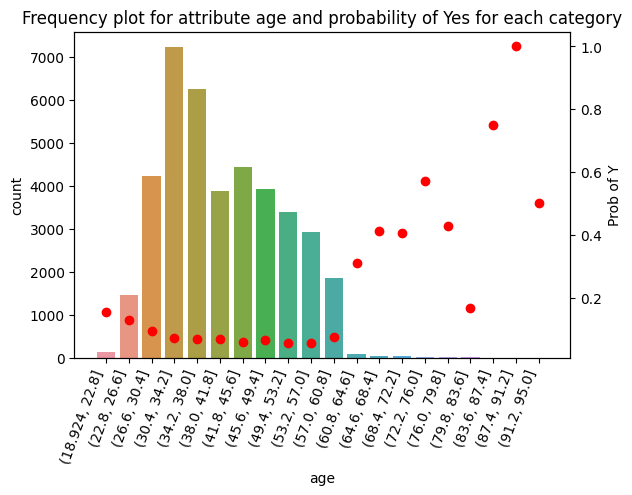

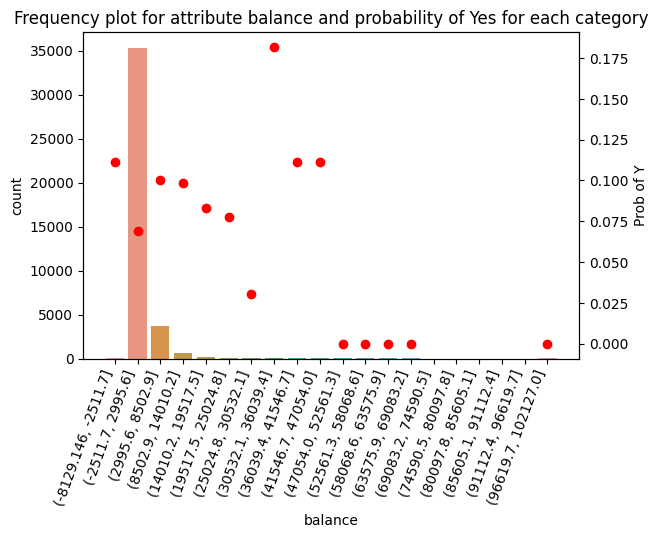

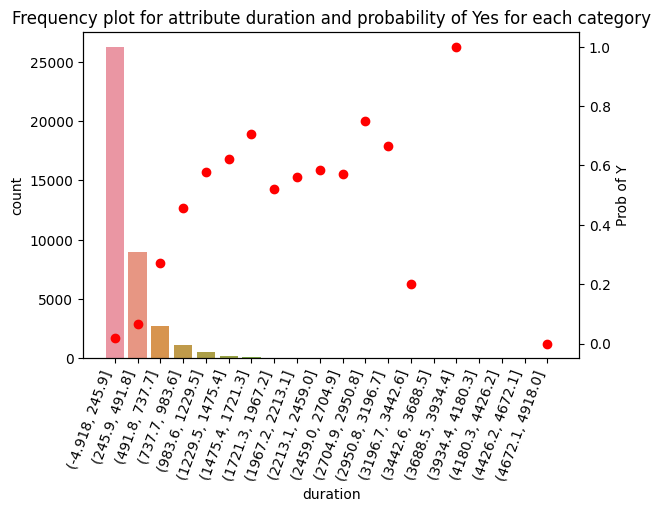

In [41]:
quant_data = raw_data.copy()

for key in ['age', 'balance', 'duration']:
  quant_data[key], bins = pd.cut(raw_data[key], bins=20, retbins=True)

  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()

  # Category frequency plot
  sns.countplot(x=key, data=quant_data, ax=ax1).set(title='Frequency plot for attribute '+ key + ' and probability of Yes for each category')

  # group by category to compute the probability of Y
  grp = quant_data.groupby(key)
  ax2.scatter(np.arange(0, grp['y'].aggregate(np.mean).shape[0]), grp['y'].aggregate(np.mean), color='r')
  ax2.set_ylabel('Prob of Y')

  fig.autofmt_xdate(rotation=70)

We observe some kind of correlation between the outcome and the categorical featues - hopefully the model will indentify and exploit such correlation.
- Also for the feature day, it seems to be some correlation.
- Feature campaign seems to have very low correlation with the label -> the probability of Yes is more or less equal no matter the value of the feature. However, in the outlier region we notice some correlation, so it might be useful to keep the outliers for this feature.
- Features age, balance and duration also show a correlation with the label, particularly in the outlier region -> might be useful to preserve the outliers for these features as well


# Exploratory Data Analysis conclusions

**Missing values**:

There are missing values in 'job', 'education', 'contact'. Options:
- substitute missing values with the most frequent one
- leave the values as missing -> additional category 
- drop the samples with missing values
- Infer the missing values using clustering (e.g. K-means) + polling from the cluster for the missing value


**Label balance**:

We notice that the dataset is highly unbalanced toward negative (13:1)
- Use XGBoost parameter scale_pos_weight
- Undersample/Oversample the database to balance it

**Outliers**:

Four features analyzed for outliers: age, balance, duration and campaign. While the age distribution is quite wide, the balance, duration and campaign distributions are extremely narrow with long tails. 

As expected from the distribution graph, the feature age has a very limited number of outliers, while the remaining three features they all have around 2% of outliers. 

Furthermore, we notice that for age and duration outliers, the probability of Yes is much higher than the dataset average (around 50% against 7%). On the other hand, the probability of Yes in the campaign outliers is lower than the average (3%).

**Correlation**:

We observe some kind of correlation between the outcome and the categorical featues - hopefully the model will indentify and exploit such correlation.
- Also for the feature day, it seems to be some correlation.
- Feature campaign shows correlation as well. In the outlier region, however, the correlation stops with the increase of the feature value.
- Features age, balance and duration also show a correlation with the label, particularly in the outlier region -> might be useful to preserve the outliers for these features as well


**Next steps**

In light of the information above, in the modelling phase we will try out different options to see which one performs the best:

*   We need to deal with missing values 
*   we need to deal with outliers


# Encoding

Now we need to encode the categorical features & the label from string to numbers.
We will use sklearn preprocessing One Hot Encoder function.

Note: we insert the one hot encoding as a **list** in the corresponding column

In [42]:
from sklearn import preprocessing

data = raw_data.copy()
numerical_keys = ['age', 'balance', 'duration', 'campaign', 'y']
month_categories = [['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]
encoders_list = {}

# perform the encoding:
for key in raw_data.keys():

  # Skip numerical features 
  if key in numerical_keys:
    continue

  # We want the months to be ordered, so we pass the categories 
  elif key == 'month':
    ohe = preprocessing.OneHotEncoder(categories=month_categories, sparse_output=False, handle_unknown='error')

  # Else, we let the function do its magic 
  else:
    ohe = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='error')
    
  input = raw_data.loc[:, key].values.reshape(-1, 1)
  output = ohe.fit_transform(input)

  # we want to create one new column for each category of the feature:
  # First we create the column names as "feature - category"
  new_col_names = []
  for cat in ohe.categories_[0]: 
    new_col_names.append(key + ' - ' + str(cat))

  # then we create a temporary dataframe with the encodings and the new column names
  new_cols = pd.DataFrame(output, columns=new_col_names)

  # then we drop the original feature, and add the One Hot encoding equivalent
  # with this approach, we don't need to save the encodings - they are embedded in the column names
  data = pd.concat([data.drop(key, axis=1), new_cols], axis=1)

In [43]:
data.head()

,age,balance,duration,campaign,y,job - admin,job - blue-collar,job - entrepreneur,job - housemaid,job - management,...,month - mar,month - apr,month - may,month - jun,month - jul,month - aug,month - sep,month - oct,month - nov,month - dec
0,58,2143,261,1,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,29,151,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33,2,76,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,1506,92,1,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,1,198,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Labels extraction

In [4]:
attributes = data.drop('y', axis=1)
labels = data['y']
labels

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: object

Note that labels have dtype=object, while we want int.
So, we need to perform a quick casting with pandas native function to_numeric()

In [5]:
labels = pd.to_numeric(labels)

# Model

This is a classification problem, so we can use **XGBoost** as a model.

This time the database is big enough, so we could also explore some **Neural Network** architectures (e.g. MLPs), and see how they perform compared to XGB. 

In [46]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(attributes, labels, test_size=0.3, random_state=23)


print('Full dataset balance: ', labels.sum() / labels.shape[0])
print('Train dataset balance: ', y_train.sum() / y_train.shape[0])
print('Test dataset balance: ', y_test.sum() / y_test.shape[0])

Full dataset balance:  0.0724
Train dataset balance:  0.072
Test dataset balance:  0.07333333333333333


In [47]:
from sklearn import model_selection
import xgboost

# let's use the scale_pos_weight parameter to deal with the unbalance
spw = (labels == 0).sum() / labels.sum()

xgb = xgboost.XGBClassifier(scale_pos_weight=spw)
xgb.fit(X_train, y_train)

pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

In [48]:
from sklearn import metrics

print('Train accuracy score: ', metrics.accuracy_score(y_train, pred_train))
print('Test accuracy score: ', metrics.accuracy_score(y_test, pred_test))
print('Train confusion matrix:')
print(metrics.confusion_matrix(y_train, pred_train))
print('Test confusion matrix:')
print(metrics.confusion_matrix(y_test, pred_test))
print('Train recall score: ', metrics.recall_score(y_train, pred_train))
print('Test recall score: ', metrics.recall_score(y_test, pred_test))
print('Train AUC score: ', metrics.roc_auc_score(y_train, pred_train))
print('Test AUC score: ', metrics.roc_auc_score(y_test, pred_test))

Train accuracy score:  0.9449285714285715
Test accuracy score:  0.9039166666666667
Train confusion matrix:
[[24449  1535]
 [    7  2009]]
Test confusion matrix:
[[10188   932]
 [  221   659]]
Train recall score:  0.9965277777777778
Test recall score:  0.7488636363636364
Train AUC score:  0.9687264812534209
Test AUC score:  0.8325253433616744


# 5-Fold Cross Validation

In [32]:
xgb = xgboost.XGBClassifier(scale_pos_weight=spw)
output = model_selection.cross_validate(xgb, attributes, labels, scoring=['accuracy', 'recall'], cv=5, return_train_score=True, return_estimator=True)

In [33]:
print('Train accuracy score: ', output['train_accuracy'].mean())
print('Test accuracy score: ', output['test_accuracy'].mean())
print('Train recall score: ', output['train_recall'].mean())
print('Test recall score: ', output['test_recall'].mean())

Train accuracy score:  0.9456562500000001
Test accuracy score:  0.5164500000000001
Train recall score:  0.9947344214833217
Test recall score:  0.24532606753618008
